[ResNet50识别Mnist数据集(Pytorch实战)](https://blog.csdn.net/weixin_42888638/article/details/122021648)

In [1]:
import torch
torch.__version__

'1.12.1'

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
# create dataset
BATCH_SIZE = 64
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet50(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=True)
    return model

In [6]:
# start training
NUM_EPOCHS = 6
model = resnet50(num_classes=10)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
valid_loader = test_loader

In [8]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 200:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc.item())
        valid_acc_lst.append(valid_acc.item())
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
print(train_acc_lst)
print(valid_acc_lst)
print(train_loss_lst)
print(valid_loss_lst)

Epoch: 001/006 | Batch 0000/0938 | Cost: 2.7708
Epoch: 001/006 | Batch 0200/0938 | Cost: 1.0404
Epoch: 001/006 | Batch 0400/0938 | Cost: 0.5662
Epoch: 001/006 | Batch 0600/0938 | Cost: 0.3982
Epoch: 001/006 | Batch 0800/0938 | Cost: 0.2951
Epoch: 001/006 Train Acc.: 92.73% | Validation Acc.: 91.28%
Time elapsed: 0.64 min
Epoch: 002/006 | Batch 0000/0938 | Cost: 0.5619
Epoch: 002/006 | Batch 0200/0938 | Cost: 0.2036
Epoch: 002/006 | Batch 0400/0938 | Cost: 0.3003
Epoch: 002/006 | Batch 0600/0938 | Cost: 0.2238
Epoch: 002/006 | Batch 0800/0938 | Cost: 0.0555
Epoch: 002/006 Train Acc.: 96.90% | Validation Acc.: 94.68%
Time elapsed: 1.26 min
Epoch: 003/006 | Batch 0000/0938 | Cost: 0.0418
Epoch: 003/006 | Batch 0200/0938 | Cost: 0.0950
Epoch: 003/006 | Batch 0400/0938 | Cost: 0.1464
Epoch: 003/006 | Batch 0600/0938 | Cost: 0.2614
Epoch: 003/006 | Batch 0800/0938 | Cost: 0.0320
Epoch: 003/006 Train Acc.: 98.36% | Validation Acc.: 96.29%
Time elapsed: 1.88 min
Epoch: 004/006 | Batch 0000/093

In [9]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 97.64%


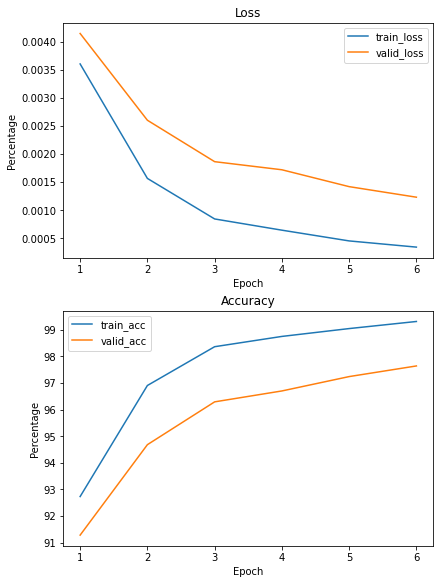

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
epoch_list = range(1,NUM_EPOCHS+1)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,8),layout='constrained')
# plot figure 1
# plt.subplot(1,2,1)
ax1.plot(epoch_list,train_loss_lst,label="train_loss")
ax1.plot(epoch_list,valid_loss_lst,label="valid_loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Percentage")
ax1.set_title("Loss")
ax1.legend()
# plot figure 2
# plt.subplot(1,2,2)
ax2.plot(epoch_list,train_acc_lst,label="train_acc")
ax2.plot(epoch_list,valid_acc_lst,label="valid_acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Percentage")
ax2.set_title("Accuracy")
ax2.legend()
# display pictures
# plt.show()
fig.show()

tensor([1, 7, 0, 4, 6, 5, 5, 4], device='cuda:0')


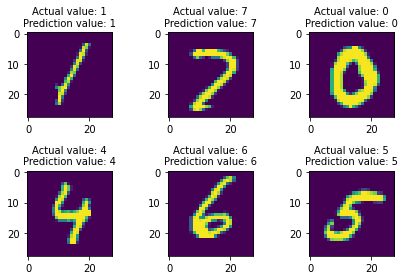

In [11]:
for features, targets in train_loader:
    break
# 预测环节
_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)
print(predictions)

features = features[:7]
fig = plt.figure()
# print(features[i].size())
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    tmp = features[i]
    plt.imshow(np.transpose(tmp, (1, 2, 0)))
    plt.title("Actual value: {}".format(targets[i])+'\n'+"Prediction value: {}".format(predictions[i]),size = 10)
    
#     plt.title("Prediction value: {}".format(tname[targets[i]]))
plt.show()